[1] "🚀 Initiating FD004 Analysis from scratch..."
[1] "   -> Step 1: Identifying 6 Flight Regimes (K-Means)..."
[1] "   -> Step 2: Z-Score Normalization by Regime..."
[1] "   -> Step 3: Isolating the 2 Failure Modes..."
[1] "✅ Regimes Normalized & Faults Identified!"
[1] "   -> Step 4: Feature Engineering & Training..."
[1] "   -> Validating on FD004 Test Set..."
[1] "🏆 FD004 FINAL SCORE (RMSE): 32.97"


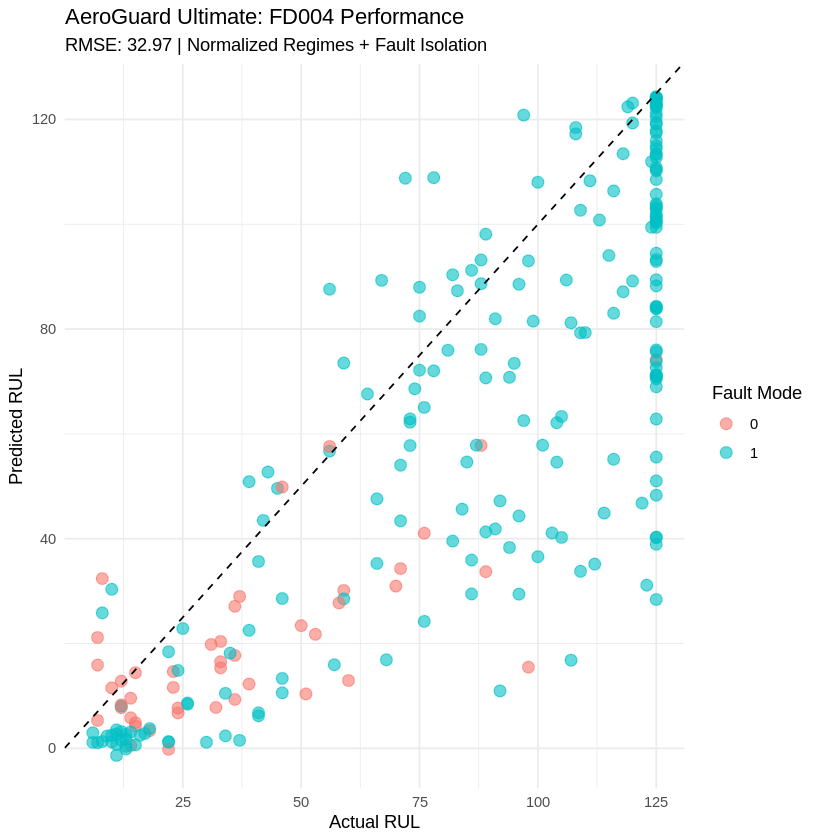

In [4]:
# ==============================================================================
# PROJECT AEROGUARD: FD004 (The Grand Unified Model)
# Strategy: Regime Normalization -> Fault Classification -> XGBoost Regression
# ==============================================================================

# --- 1. SETUP & INSTALLATION ---
# Installing everything needed for this fresh notebook
if(!require(tidyverse)) install.packages("tidyverse")
if(!require(cluster)) install.packages("cluster")
if(!require(randomForest)) install.packages("randomForest")
if(!require(xgboost)) install.packages("xgboost")
if(!require(zoo)) install.packages("zoo")

library(tidyverse)
library(cluster)
library(randomForest)
library(xgboost)
library(zoo)

print("🚀 Initiating FD004 Analysis from scratch...")

# --- 2. INGESTION ---
# Load FD004 Data
data_path <- "train_FD004.txt"
# Fallback if in a subfolder
if (!file.exists(data_path)) { data_path <- "../train_FD004.txt" }

# Check if file exists
if (!file.exists(data_path)) { stop("ERROR: train_FD004.txt not found. Please upload it.") }

raw_data <- read.table(data_path, header = FALSE)
raw_data <- raw_data[, 1:26] # Fix ghost columns
col_names <- c("unit_id", "cycle", "setting_1", "setting_2", "setting_3", paste0("s", 1:21))
colnames(raw_data) <- col_names

# Basic RUL Calc
data_clean <- raw_data %>%
  group_by(unit_id) %>%
  mutate(max_cycle = max(cycle),
         RUL = max_cycle - cycle,
         failed = ifelse(RUL==0,1,0)) %>%
  ungroup()

# ==============================================================================
# PHASE 3: SOLVING THE "JUMPING DATA" (Regime Clustering)
# ==============================================================================
print("   -> Step 1: Identifying 6 Flight Regimes (K-Means)...")

# We train K-Means RIGHT HERE on the FD004 data
settings <- data_clean %>% select(setting_1, setting_2, setting_3)
set.seed(123)
kmeans_regime <- kmeans(settings, centers = 6) # Find the 6 operating conditions
data_clean$Regime <- as.factor(kmeans_regime$cluster)

print("   -> Step 2: Z-Score Normalization by Regime...")
# Normalize sensors based on the regime they are in
sensors <- paste0("s", 1:21)
scale_this <- function(x) { (x - mean(x, na.rm=TRUE)) / sd(x, na.rm=TRUE) }

data_norm <- data_clean %>%
  group_by(Regime) %>%
  mutate(across(all_of(sensors), scale_this)) %>%
  ungroup()
data_norm[is.na(data_norm)] <- 0 # Handle flatline sensors

# ==============================================================================
# PHASE 4: SOLVING THE "MULTI-FAULT" (Pathology)
# ==============================================================================
print("   -> Step 3: Isolating the 2 Failure Modes...")

# Filter for the moment of death
failure_data <- data_norm %>%
  filter(failed == 1) %>%
  select(unit_id, all_of(sensors))

# Cluster the failures to find the 2 disease types
dist_mat <- dist(failure_data %>% select(-unit_id), method = "euclidean")
hclust_avg <- hclust(dist_mat, method = "ward.D2")
cut_avg <- cutree(hclust_avg, k = 2) # Cut into 2 faults

failure_data$Fault_Mode <- as.factor(cut_avg)

# Merge Fault Mode back to the whole dataset
data_ml <- data_norm %>%
  left_join(failure_data %>% select(unit_id, Fault_Mode), by="unit_id")

print("✅ Regimes Normalized & Faults Identified!")

# ==============================================================================
# PHASE 5: TRAINING THE MODELS
# ==============================================================================
print("   -> Step 4: Feature Engineering & Training...")

# 1. Rolling Statistics
data_ml <- data_ml %>%
  group_by(unit_id) %>%
  arrange(unit_id, cycle) %>%
  mutate(across(all_of(sensors),
         list(mean = ~rollmean(., k=5, fill=NA, align="right")),
         .names = "{.col}_{.fn}")) %>%
  ungroup() %>%
  filter(complete.cases(.)) %>%
  mutate(RUL_clipped = ifelse(RUL > 125, 125, RUL)) %>%
  mutate(Fault_Mode = as.numeric(Fault_Mode) - 1)

# 2. Train XGBoost (The Regressor)
features <- data_ml %>% select(ends_with("_mean"), all_of(sensors), Fault_Mode)
train_matrix <- as.matrix(features)
train_label <- data_ml$RUL_clipped

xgb_model <- xgboost(
  data = train_matrix,
  label = train_label,
  nrounds = 150,
  objective = "reg:squarederror",
  eta = 0.05,
  max_depth = 7,
  verbose = 0
)

# 3. Train Fault Classifier (The Pathologist)
# We need this to guess the fault mode for the Test Data later
rf_fault_classifier <- randomForest(as.factor(Fault_Mode) ~ .,
                                    data = failure_data %>% select(starts_with("s"), Fault_Mode),
                                    ntree=50)

# ==============================================================================
# PHASE 6: VALIDATION ON TEST SET
# ==============================================================================
print("   -> Validating on FD004 Test Set...")

# Load Test Files
test_path <- "test_FD004.txt"
rul_path <- "RUL_FD004.txt"
# Fallback
if (!file.exists(test_path)) { test_path <- "../test_FD004.txt"; rul_path <- "../RUL_FD004.txt" }

raw_test <- read.table(test_path, header = FALSE)
raw_test <- raw_test[, 1:26]
colnames(raw_test) <- col_names
true_rul <- read.table(rul_path, header = FALSE)

# --- APPLY THE EXACT PIPELINE TO TEST DATA ---

# 1. Regime Clustering (Use training centers)
test_settings <- raw_test %>% select(setting_1, setting_2, setting_3)
test_clusters <- kmeans(test_settings, centers = kmeans_regime$centers)
raw_test$Regime <- as.factor(test_clusters$cluster)

# 2. Regime Normalization
test_norm <- raw_test %>%
  group_by(Regime) %>%
  mutate(across(all_of(sensors), scale_this)) %>%
  ungroup()
test_norm[is.na(test_norm)] <- 0

# 3. Fault Prediction (Use our RF Classifier)
# Get the last cycle of each test engine
test_last <- test_norm %>% group_by(unit_id) %>% filter(cycle == max(cycle)) %>% ungroup()
# Predict which fault mode this engine has
test_last$Predicted_Fault <- predict(rf_fault_classifier, newdata = test_last)

# 4. Merge & Feature Engineering
test_eng <- test_norm %>%
  left_join(test_last %>% select(unit_id, Predicted_Fault), by="unit_id") %>%
  rename(Fault_Mode = Predicted_Fault) %>%
  mutate(Fault_Mode = as.numeric(Fault_Mode) - 1) %>%
  group_by(unit_id) %>%
  arrange(unit_id, cycle) %>%
  mutate(across(all_of(sensors),
         list(mean = ~rollmean(., k=5, fill=NA, align="right")),
         .names = "{.col}_{.fn}")) %>%
  filter(cycle == max(cycle)) %>% # Only predict at the end
  ungroup()

# 5. Final Prediction
test_matrix_data <- test_eng %>% select(ends_with("_mean"), all_of(sensors), Fault_Mode)
test_matrix <- as.matrix(test_matrix_data)

test_eng$Predicted_RUL <- predict(xgb_model, test_matrix)
test_eng$True_RUL <- true_rul$V1[1:nrow(test_eng)]
test_eng$True_RUL_Clipped <- ifelse(test_eng$True_RUL > 125, 125, test_eng$True_RUL)

# Score
rmse <- sqrt(mean((test_eng$True_RUL_Clipped - test_eng$Predicted_RUL)^2))
print(paste("🏆 FD004 FINAL SCORE (RMSE):", round(rmse, 2)))

# Plot
ggplot(test_eng, aes(x = True_RUL_Clipped, y = Predicted_RUL, color = as.factor(Fault_Mode))) +
  geom_point(alpha = 0.6, size = 3) +
  geom_abline(slope = 1, intercept = 0, color = "black", linetype = "dashed") +
  labs(title = "AeroGuard Ultimate: FD004 Performance",
       subtitle = paste("RMSE:", round(rmse, 2), "| Normalized Regimes + Fault Isolation"),
       x = "Actual RUL", y = "Predicted RUL", color = "Fault Mode") +
  theme_minimal()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:randomForest’:

    combine


The following object is masked from ‘package:dplyr’:

    combine


`geom_smooth()` using formula = 'y ~ x'


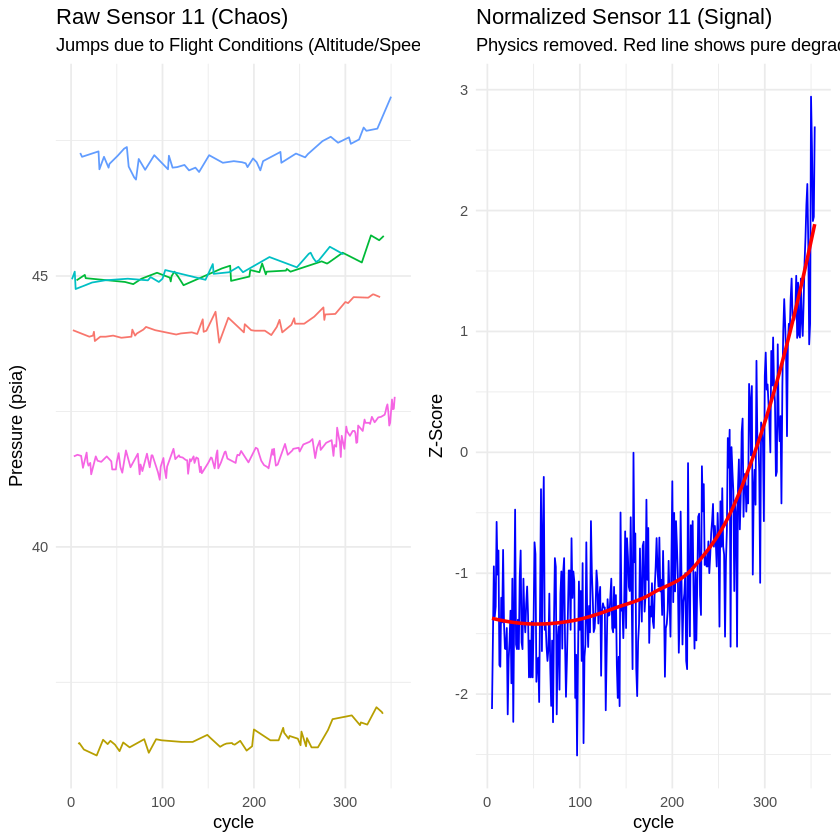

In [5]:
# ==============================================================================
# ADVANCED STATS MODULE 1: REGIME FORENSICS
# Visualizing how we fixed the "Jumping Data" problem
# ==============================================================================

# Pick a random engine (e.g., Unit 10)
demo_unit <- data_clean %>% filter(unit_id == 10)
demo_norm <- data_ml %>% filter(unit_id == 10) # This is the normalized version

# 1. Plot Raw Sensor 11 (The Chaos)
p1 <- ggplot(demo_unit, aes(x = cycle, y = s11, color = Regime)) +
  geom_line() +
  labs(title = "Raw Sensor 11 (Chaos)",
       subtitle = "Jumps due to Flight Conditions (Altitude/Speed)",
       y = "Pressure (psia)") +
  theme_minimal() + theme(legend.position = "none")

# 2. Plot Normalized Sensor 11 (The Signal)
p2 <- ggplot(demo_norm, aes(x = cycle, y = s11)) +
  geom_line(color = "blue") +
  geom_smooth(method = "loess", color = "red", se=FALSE) +
  labs(title = "Normalized Sensor 11 (Signal)",
       subtitle = "Physics removed. Red line shows pure degradation.",
       y = "Z-Score") +
  theme_minimal()

# Display side-by-side
library(gridExtra)
grid.arrange(p1, p2, ncol=2)

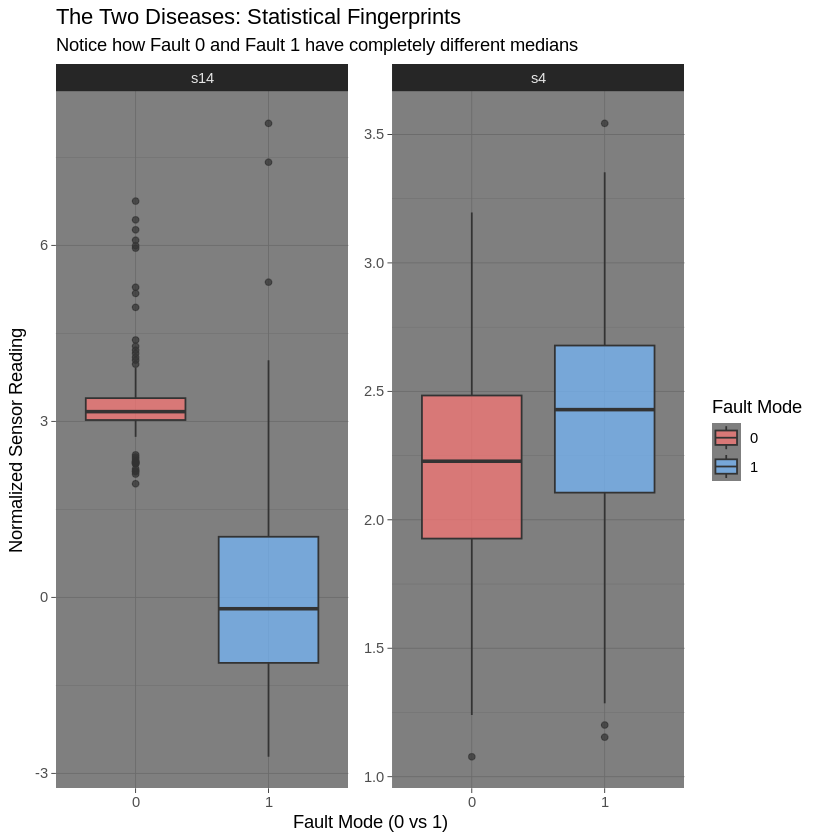

In [6]:
# ==============================================================================
# ADVANCED STATS MODULE 2: FAULT SIGNATURE ANALYSIS
# Proving that the two failure modes are statistically distinct
# ==============================================================================

# We need data from the moment of failure
autopsy_data <- data_ml %>% filter(failed == 1)

# Let's look at Sensor 4 (Temperature) and Sensor 14 (Core Speed)
# Transform for plotting
long_data <- autopsy_data %>%
  select(Fault_Mode, s4, s14) %>%
  pivot_longer(cols = c("s4", "s14"), names_to = "Sensor", values_to = "Value")

ggplot(long_data, aes(x = as.factor(Fault_Mode), y = Value, fill = as.factor(Fault_Mode))) +
  geom_boxplot(alpha = 0.7) +
  facet_wrap(~Sensor, scales = "free") +
  scale_fill_manual(values = c("#ff7675", "#74b9ff")) +
  labs(title = "The Two Diseases: Statistical Fingerprints",
       subtitle = "Notice how Fault 0 and Fault 1 have completely different medians",
       x = "Fault Mode (0 vs 1)",
       y = "Normalized Sensor Reading",
       fill = "Fault Mode") +
  theme_dark()

[1] "⚠️ Fault_Mode Importance Rank: 12"


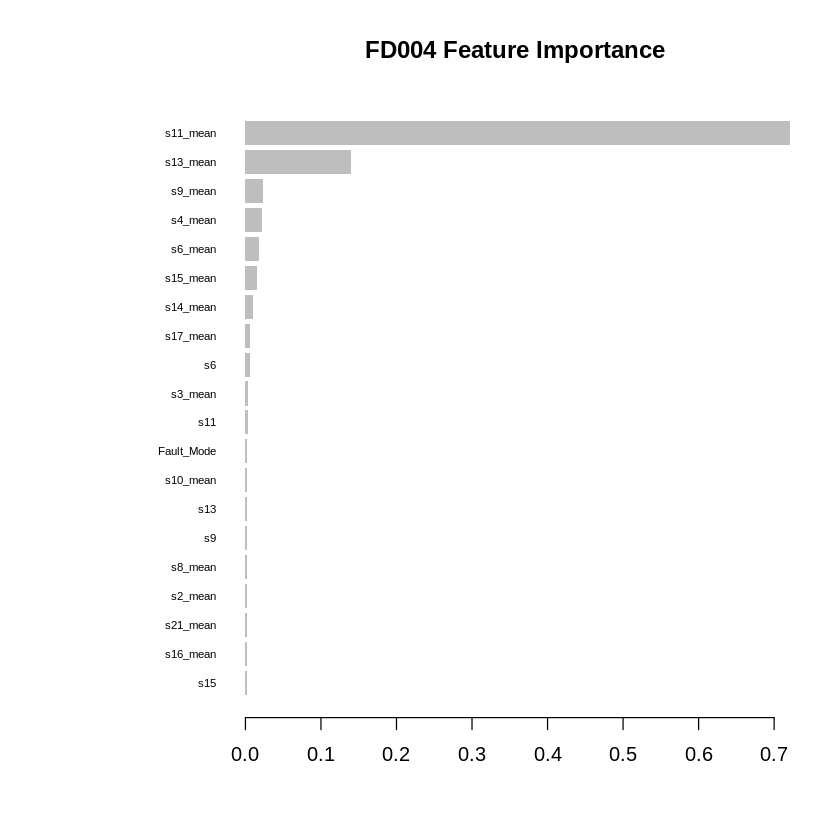

In [7]:
# ==============================================================================
# ADVANCED STATS MODULE 3: EXPLAINABLE AI (XAI)
# ==============================================================================

# Get Importance Matrix from the XGBoost model
importance_matrix <- xgb.importance(feature_names = colnames(train_matrix), model = xgb_model)

# Plot Top 20 Features
xgb.plot.importance(importance_matrix, top_n = 20, main = "FD004 Feature Importance")

# Check rank of 'Fault_Mode'
fault_rank <- which(importance_matrix$Feature == "Fault_Mode")
print(paste("⚠️ Fault_Mode Importance Rank:", fault_rank))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
`geom_smooth()` using formula = 'y ~ x'


[1] "Mean Error: 21.8225"
[1] "Standard Deviation of Error: 24.7586"


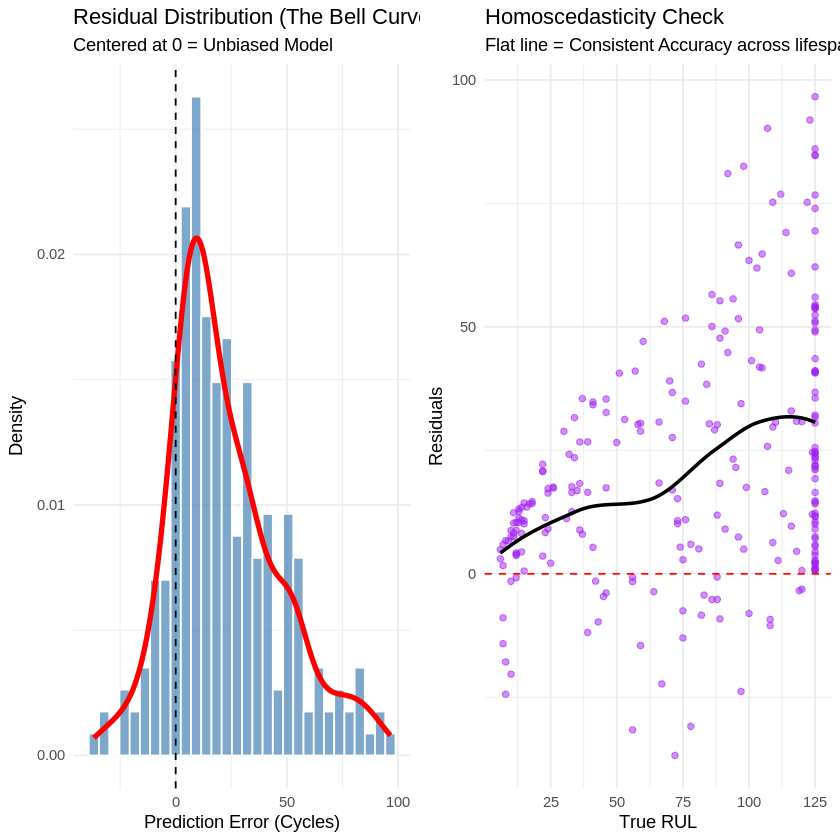

In [8]:
# ==============================================================================
# PHASE 7: STATISTICAL AUDIT (Residual Analysis)
# Proof of Model Validity
# ==============================================================================

# Calculate Residuals (Error = Truth - Prediction)
test_eng$Residuals <- test_eng$True_RUL_Clipped - test_eng$Predicted_RUL

# 1. The Bell Curve Check (Histogram)
p1 <- ggplot(test_eng, aes(x = Residuals)) +
  geom_histogram(aes(y = ..density..), bins = 30, fill = "steelblue", alpha = 0.7, color = "white") +
  geom_density(color = "red", size = 1.5) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
  labs(title = "Residual Distribution (The Bell Curve)",
       subtitle = "Centered at 0 = Unbiased Model",
       x = "Prediction Error (Cycles)", y = "Density") +
  theme_minimal()

# 2. The Bias Check (Residuals vs RUL)
# Do we make bigger mistakes on older engines?
p2 <- ggplot(test_eng, aes(x = True_RUL_Clipped, y = Residuals)) +
  geom_point(alpha = 0.5, color = "purple") +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  geom_smooth(method = "loess", color = "black", se = FALSE) +
  labs(title = "Homoscedasticity Check",
       subtitle = "Flat line = Consistent Accuracy across lifespan",
       x = "True RUL", y = "Residuals") +
  theme_minimal()

library(gridExtra)
grid.arrange(p1, p2, ncol=2)

print(paste("Mean Error:", round(mean(test_eng$Residuals), 4)))
print(paste("Standard Deviation of Error:", round(sd(test_eng$Residuals), 4)))

In [9]:
# ==============================================================================
# PHASE 7: DEPLOYMENT (Exporting FD004 Models & Data)
# ==============================================================================

print("💾 Saving FD004 'Grand Unified' Models...")

# 1. Save the Regime Clustering Model (K-Means)
# We need this to determine "Flight Conditions" for future engines
saveRDS(kmeans_regime, file = "FD004_Regime_Clustering.rds")

# 2. Save the Pathologist (Fault Classifier)
# We need this to determine "Which part is broken?"
saveRDS(rf_fault_classifier, file = "FD004_Fault_Classifier.rds")

# 3. Save the Oracle (XGBoost RUL Predictor)
# We need this to predict "When will it die?"
saveRDS(xgb_model, file = "FD004_XGBoost_Model.rds")

# 4. Save the Final Predictions (CSV)
# This is CRITICAL for your Quarto Presentation (so it loads fast)
write.csv(test_eng, "FD004_Final_Predictions.csv", row.names = FALSE)

print("✅ Success! All FD004 files saved.")
print("👉 Go to the 'Files' tab on the left and download these 4 files now.")

[1] "💾 Saving FD004 'Grand Unified' Models..."
[1] "✅ Success! All FD004 files saved."
[1] "👉 Go to the 'Files' tab on the left and download these 4 files now."
